In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

#### Define the Decision Tree structure

In [2]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Base criteria that stops recursion
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return TreeNode(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Select the best split with information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow childNodes from split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return TreeNode(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # Generate split indexes
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted average of loss for children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

#### Define the Random Forest structure

In [3]:
def sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

def most_common_label(y):
    """
    Returns the common labels in a sample
    """
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

#### Data Processing

In [4]:
NUMBER_OF_TREES = 5
MAX_DEPTH = 10
NUMBER_OF_SAMPLES = 6000
TEST_SPLIT = 0.2
PCA_VARIANCE = 0.99

def scale(train_x, test_x):
    """
    Applies Scaler transformations to input arrays
    """
    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    return train_x, test_x

def pca_features(train_x, test_x):
    """
    Reduces input dimensions of arrays
    """
    # Make an instance of the Model
    pca = PCA(PCA_VARIANCE)
    pca.fit(train_x)
    train_x = pca.transform(train_x)
    test_x = pca.transform(test_x)
    return train_x, test_x

def train_test_split(df, test_size):
    """
    Creates a test and train dataframe split
    """
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

def preprocess_data(df, shuffle_rows=None):
    """
    Applies necessary processing steps before passed on to the model
    """
    if type(df) == str:
        df = pd.read_csv(df)
        # Look for 'slice_id' column along the rows and remove it
        df = df.drop("slice_id", axis=1)
        
    if shuffle_rows and isinstance(shuffle_rows, int):
        for i in range(shuffle_rows):
            df = shuffle(df)
            
    # Limit the number of rows for using in training
    df = df.iloc[0:NUMBER_OF_SAMPLES]
    train_df, test_df = train_test_split(df, test_size=TEST_SPLIT)
    # Extract the training and testing values
    train_values, test_values = train_df.values, test_df.values
    train_val = train_values[:,1:-1]
    test_val = test_values[:, 1:-1]
    # Extract the labels
    train_label, test_label = train_values[:,-1].astype('int32'), test_values[:,-1].astype('int32')
    # Get scaled value
    train_x, test_x = scale(train_val, test_val)
    # Reduce Dimension
    train_x, test_x = pca_features(train_x, test_x)
    return train_x, train_label, test_x, test_label

### Normal vs. Abnormal Classification

In [15]:
path_to_csv = "C:\\Users\\mail2\\OneDrive\\Desktop\\Projects\\covid_projects\\decision_tree\\normal_abnormal.csv"
train_x, train_label, test_x, test_label = preprocess_data(path_to_csv, 4)

# Fit the classifier
model = RandomForest(n_trees=NUMBER_OF_TREES, max_depth=MAX_DEPTH)
model.fit(train_x, train_label)

#### Evaluation Metrics

In [81]:
y_prediction = model.predict(test_x)

In [111]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

cm = confusion_matrix(test_label, y_prediction)
model_acc = accuracy(test_label, y_prediction)
print("Validation Accuracy: {:.6f}".format(model_acc))
print("="*60)
print("Confusion Matrix\n-----------\n{}".format(cm))
print("="*60)
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_label, y_prediction, target_names=target_names))

Validation Accuracy: 0.813333
Confusion Matrix
-----------
[[607  99]
 [125 369]]
              precision    recall  f1-score   support

      Normal       0.83      0.86      0.84       706
   Pneumonia       0.79      0.75      0.77       494

    accuracy                           0.81      1200
   macro avg       0.81      0.80      0.81      1200
weighted avg       0.81      0.81      0.81      1200



[2 1 0]
AUC: 0.803


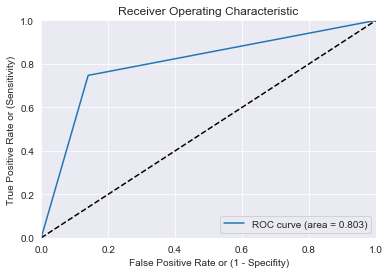

In [108]:
fpr, tpr, thresholds = roc_curve(test_label, y_prediction)
print(thresholds)

auc = roc_auc_score(test_label, y_prediction)
print('AUC: %.3f' % auc)

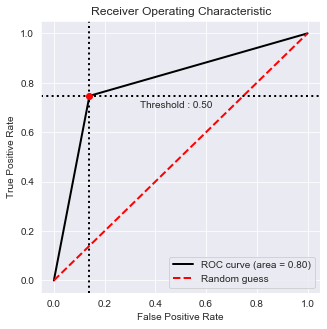

In [106]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(test_label, y_prediction, labels=["Normal", "Pneumonia"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### Covid vs. Pneumonia Classification

0       0
1       0
2       0
3       0
4       0
       ..
5317    1
5318    1
5319    1
5320    1
5321    1
Name: label, Length: 5322, dtype: int64


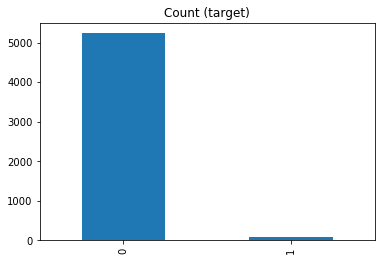

In [5]:
path_to_csv = "C:\\Users\\mail2\\OneDrive\\Desktop\\Projects\\covid_projects\\decision_tree\\pn_covid.csv"
train = pd.read_csv(path_to_csv)

# Gives a list of columns after dropping the included two
labels = train.columns.drop(['slice_id', 'label'])
target = train['label'] # Get the target values
print(target)

# See the class difference
train['label'].value_counts().plot(kind='bar', title='Count (target)');

**Balance** the **dataset** with **synthetic samples (SMOTE)**
- **Perform** an **oversampling**, which **consists** of **creating new samples** to **increase** the **minority class**. 
- **SMOTE (Synthetic Minority Oversampling TEchnique)** consists of **synthesizing elements** for the **minority class**, based on **those** that **already exist**.
    - It **works randomly** picking a **point** from the **minority class** and **computing** the **k-nearest neighbors** for **this point**. The **synthetic points** are **added** between the **chosen point** and **its neighbors**.

Using TensorFlow backend.


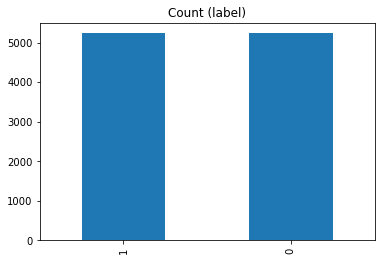

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
x_sm, y_sm = smote.fit_resample(train[labels], train['label'])
df = pd.DataFrame(x_sm, columns=labels)

df['label'] = y_sm
df['label'].value_counts().plot(kind='bar', title='Count (label)');

In [7]:
train_x, train_label, test_x, test_label = preprocess_data(df, 4)

In [8]:
# Fit the classifier
model = RandomForest(n_trees=NUMBER_OF_TREES, max_depth=MAX_DEPTH)
model.fit(train_x, train_label)

#### Evaluation Metrics

In [9]:
y_prediction = model.predict(test_x)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

cm = confusion_matrix(test_label, y_prediction)
model_acc = accuracy(test_label, y_prediction)
print("Validation Accuracy: {:.6f}".format(model_acc))
print("="*60) 
print("Confusion Matrix\n-----------\n{}".format(cm))
print("="*60)
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_label, y_prediction, target_names=target_names))

Validation Accuracy: 0.988333
Confusion Matrix
-----------
[[561   7]
 [  7 625]]
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       568
   Pneumonia       0.99      0.99      0.99       632

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [10]:
fpr, tpr, thresholds = roc_curve(test_label, y_prediction)
print(thresholds)

auc = roc_auc_score(test_label, y_prediction)
print('AUC: %.3f' % auc)

[2 1 0]
AUC: 0.988


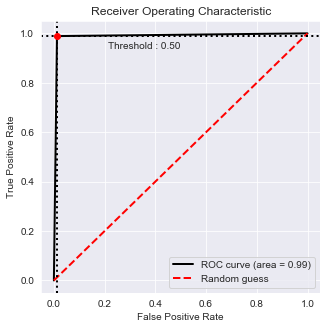

In [11]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(test_label, y_prediction, labels=["Normal", "Pneumonia"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()